# PyTorch cnn FMNIST with regularization 

We apply the following regularization techniques:
* L1 & L2 Regularization
* Data augmentation
* Drop out
* Early stopping
* Batch normalization

In [92]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# check if cuda is usable
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

print(f"Using device: {device}")

Using device: cuda


In [93]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.report import show_torch_image

In [94]:
!mkdir -p ./out/

## Build CNN for FMNIST without regularization

### Dataset loading and transform

In [95]:
normalizing_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])

trainset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                             train=True,
                                             download=True, 
                                             transform=normalizing_transform)


testset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                            train=False,
                                            download=True, 
                                            transform=normalizing_transform)
print(f'train: {trainset.data.shape}')
print(f'test: {testset.data.shape}')


print(f'classes: {trainset.class_to_idx}')
class_names = list(trainset.class_to_idx.keys())
print(f'class_names: {class_names}')

train: torch.Size([60000, 28, 28])
test: torch.Size([10000, 28, 28])
classes: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
class_names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


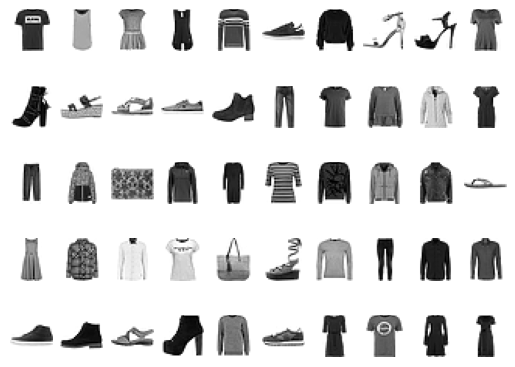

In [96]:
figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

In [97]:
batch_size = 64
epochs = 5
if device == 'cuda':
    batch_size = 256
    epochs = 70


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

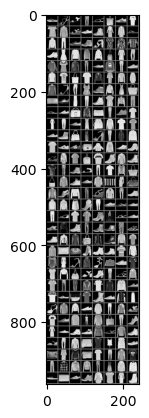

Sandal Sandal Sandal Trouser Sandal   Bag Sneaker Dress


In [98]:
# get random training images
train_iter = iter(trainloader)
images, labels = next(train_iter)

show_torch_image(torchvision.utils.make_grid(images))

print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))

### Model definition

In [99]:
class NetNoReg(nn.Module):
    def __init__(self):
        super(NetNoReg, self).__init__()

        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_1 = nn.Linear(64 * 12 * 12, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


net = NetNoReg()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training the model
We define the training loop as a function to be able to re-use it

In [100]:
def train(model, epochs, trainloader, testloader, criterion, optimizer, model_path = None):
    epoch_log = []
    loss_log = []
    accuracy_log = []

    print(f'------- Starting training for {epochs} epochs, batch_size: {batch_size} -------')
    for epoch in tqdm(range(epochs), desc="Total train progress", position=0):
        running_loss = 0.0

        for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1}', position=1, leave=False), 0):
        
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # clear the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
            # backpropagation and update of weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # run against test dataset
            if i % 10 == 0:
                correct = 0
                total = 0

                # no gradients needed for testing
                with torch.no_grad():
                    for images, labels in testloader:
                        images = images.to(device)
                        labels = labels.to(device)
                    
                        outputs = model(images)

                         # predictions from the maximum value of the predicted output tensor
                         # we set dim = 1 to reduce the dimensions
                        _, predicted = torch.max(outputs.data, dim = 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 10
                    running_loss = 0.0
    
        # update logs after each epoch
        print(f'Epoch {epoch_num}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)

    if model_path != None:
        torch.save(net.state_dict(), model_path)
        print(f"Saved to: '{model_path}'") 
    print('------- Training done! -------') 
    return epoch_log, loss_log, accuracy_log

### Train without regularization

In [101]:
epoch_log, loss_log, accuracy_log = train(net, epochs, trainloader, testloader, criterion, optimizer, model_path = './out/fmnist_cnn_no_reg.pth')

------- Starting training for 70 epochs, batch_size: 256 -------


Total train progress:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, Loss: 0.632, Test Accuracy = 74.610%


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, Loss: 0.573, Test Accuracy = 78.450%


Epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, Loss: 0.539, Test Accuracy = 79.980%


Epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, Loss: 0.479, Test Accuracy = 81.500%


Epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, Loss: 0.469, Test Accuracy = 82.610%


Epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, Loss: 0.427, Test Accuracy = 82.850%


Epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, Loss: 0.421, Test Accuracy = 82.350%


Epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, Loss: 0.431, Test Accuracy = 83.650%


Epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, Loss: 0.416, Test Accuracy = 84.030%


Epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10, Loss: 0.377, Test Accuracy = 84.310%


Epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11, Loss: 0.423, Test Accuracy = 85.170%


Epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12, Loss: 0.364, Test Accuracy = 85.530%


Epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13, Loss: 0.420, Test Accuracy = 85.530%


Epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14, Loss: 0.383, Test Accuracy = 85.250%


Epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15, Loss: 0.359, Test Accuracy = 84.840%


Epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16, Loss: 0.362, Test Accuracy = 85.300%


Epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17, Loss: 0.353, Test Accuracy = 86.900%


Epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18, Loss: 0.340, Test Accuracy = 87.130%


Epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19, Loss: 0.287, Test Accuracy = 87.000%


Epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20, Loss: 0.318, Test Accuracy = 87.250%


Epoch 21:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21, Loss: 0.319, Test Accuracy = 87.450%


Epoch 22:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22, Loss: 0.335, Test Accuracy = 87.520%


Epoch 23:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23, Loss: 0.314, Test Accuracy = 88.060%


Epoch 24:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24, Loss: 0.316, Test Accuracy = 88.120%


Epoch 25:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25, Loss: 0.291, Test Accuracy = 88.120%


Epoch 26:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26, Loss: 0.289, Test Accuracy = 87.910%


Epoch 27:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27, Loss: 0.289, Test Accuracy = 88.280%


Epoch 28:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28, Loss: 0.292, Test Accuracy = 87.530%


Epoch 29:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29, Loss: 0.306, Test Accuracy = 88.000%


Epoch 30:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30, Loss: 0.291, Test Accuracy = 87.720%


Epoch 31:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31, Loss: 0.280, Test Accuracy = 88.990%


Epoch 32:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32, Loss: 0.286, Test Accuracy = 88.530%


Epoch 33:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33, Loss: 0.272, Test Accuracy = 88.620%


Epoch 34:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34, Loss: 0.255, Test Accuracy = 88.970%


Epoch 35:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35, Loss: 0.267, Test Accuracy = 89.020%


Epoch 36:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36, Loss: 0.275, Test Accuracy = 89.260%


Epoch 37:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37, Loss: 0.261, Test Accuracy = 89.580%


Epoch 38:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38, Loss: 0.251, Test Accuracy = 89.050%


Epoch 39:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39, Loss: 0.258, Test Accuracy = 89.180%


Epoch 40:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40, Loss: 0.232, Test Accuracy = 89.550%


Epoch 41:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41, Loss: 0.251, Test Accuracy = 89.480%


Epoch 42:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42, Loss: 0.256, Test Accuracy = 89.620%


Epoch 43:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43, Loss: 0.238, Test Accuracy = 89.570%


Epoch 44:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44, Loss: 0.225, Test Accuracy = 89.880%


Epoch 45:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45, Loss: 0.204, Test Accuracy = 89.420%


Epoch 46:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46, Loss: 0.255, Test Accuracy = 89.200%


Epoch 47:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47, Loss: 0.232, Test Accuracy = 89.750%


Epoch 48:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48, Loss: 0.220, Test Accuracy = 89.630%


Epoch 49:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49, Loss: 0.232, Test Accuracy = 89.900%


Epoch 50:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50, Loss: 0.221, Test Accuracy = 90.240%


Epoch 51:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51, Loss: 0.241, Test Accuracy = 89.400%


Epoch 52:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52, Loss: 0.216, Test Accuracy = 89.700%


Epoch 53:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53, Loss: 0.208, Test Accuracy = 90.200%


Epoch 54:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54, Loss: 0.222, Test Accuracy = 90.080%


Epoch 55:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55, Loss: 0.212, Test Accuracy = 89.890%


Epoch 56:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56, Loss: 0.197, Test Accuracy = 89.660%


Epoch 57:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57, Loss: 0.220, Test Accuracy = 90.140%


Epoch 58:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58, Loss: 0.201, Test Accuracy = 90.440%


Epoch 59:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59, Loss: 0.192, Test Accuracy = 89.870%


Epoch 60:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60, Loss: 0.208, Test Accuracy = 90.640%


Epoch 61:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 61, Loss: 0.192, Test Accuracy = 90.380%


Epoch 62:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 62, Loss: 0.197, Test Accuracy = 90.550%


Epoch 63:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 63, Loss: 0.189, Test Accuracy = 90.340%


Epoch 64:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 64, Loss: 0.199, Test Accuracy = 89.860%


Epoch 65:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 65, Loss: 0.202, Test Accuracy = 90.820%


Epoch 66:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 66, Loss: 0.194, Test Accuracy = 89.520%


Epoch 67:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 67, Loss: 0.187, Test Accuracy = 90.040%


Epoch 68:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 68, Loss: 0.191, Test Accuracy = 90.620%


Epoch 69:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 69, Loss: 0.198, Test Accuracy = 90.930%


Epoch 70:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 70, Loss: 0.176, Test Accuracy = 90.800%
Saved to: './out/fmnist_cnn_no_reg.pth'
------- Training done! -------


### Plot training results

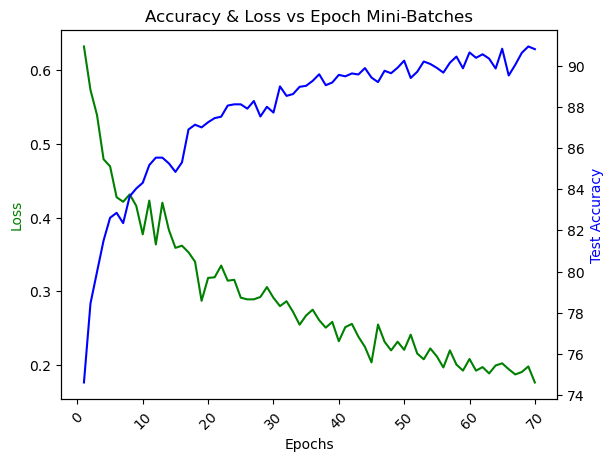

In [102]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

## Build CNN for FMNIST with regularization

### Data augmentation
We can add more transformations to perform data augmentation

In [103]:
import PIL

augmentation_transform = transforms.Compose([
        transforms.RandomAffine(degrees = 25, translate = (0.1,0.1), shear = 10), 
        transforms.ColorJitter(hue = .1, saturation = .1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25, interpolation = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        normalizing_transform
])

# we apply those new transforms only to the training set
trainset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                             train=True,
                                             download=True, 
                                             transform=augmentation_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

### Add dropout and batch normalization
We add some dropout after the conv layers and a batch normalization layer between the conv layers.

In [104]:
class NetWithReg(nn.Module):
    def __init__(self):
        super(NetWithReg, self).__init__()

        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_1_norm = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.conv_2_norm = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_1 = nn.Linear(64 * 12 * 12, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.drop_out = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv_1_norm(self.conv_1(x))
        x = F.relu(x)
        x = self.drop_out(x)
        x = self.conv_2_norm(self.conv_2(x))
        x = F.relu(x)
        x = self.drop_out(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


net = NetWithReg()
net.to(device)

NetWithReg(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_1_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_2_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

### L1 & L2 Regularization
Makes our network prefer to learn smaller weights by penalizing large weights in the loss function.  
L2 Regularization can be included in most optimizers by using the parameter `weight_decay.`

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

### Train with regularization

In [106]:
epoch_log, loss_log, accuracy_log = train(net, epochs, trainloader, testloader, criterion, optimizer, model_path = './out/fmnist_cnn_with_reg.pth')

------- Starting training for 70 epochs, batch_size: 256 -------


Total train progress:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, Loss: 0.942, Test Accuracy = 73.480%


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, Loss: 0.851, Test Accuracy = 75.760%


Epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, Loss: 0.740, Test Accuracy = 77.210%


Epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, Loss: 0.714, Test Accuracy = 78.340%


Epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, Loss: 0.663, Test Accuracy = 79.460%


Epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, Loss: 0.631, Test Accuracy = 79.670%


Epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, Loss: 0.672, Test Accuracy = 80.140%


Epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, Loss: 0.618, Test Accuracy = 81.220%


Epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, Loss: 0.613, Test Accuracy = 81.700%


Epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10, Loss: 0.610, Test Accuracy = 81.630%


Epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11, Loss: 0.595, Test Accuracy = 81.880%


Epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12, Loss: 0.529, Test Accuracy = 82.560%


Epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13, Loss: 0.567, Test Accuracy = 82.710%


Epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14, Loss: 0.583, Test Accuracy = 83.180%


Epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15, Loss: 0.515, Test Accuracy = 83.540%


Epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16, Loss: 0.561, Test Accuracy = 83.320%


Epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17, Loss: 0.541, Test Accuracy = 84.310%


Epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18, Loss: 0.527, Test Accuracy = 84.360%


Epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19, Loss: 0.534, Test Accuracy = 84.200%


Epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20, Loss: 0.526, Test Accuracy = 84.760%


Epoch 21:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21, Loss: 0.515, Test Accuracy = 84.810%


Epoch 22:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22, Loss: 0.512, Test Accuracy = 84.840%


Epoch 23:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23, Loss: 0.494, Test Accuracy = 85.230%


Epoch 24:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24, Loss: 0.487, Test Accuracy = 84.580%


Epoch 25:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25, Loss: 0.512, Test Accuracy = 85.520%


Epoch 26:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26, Loss: 0.468, Test Accuracy = 85.490%


Epoch 27:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27, Loss: 0.458, Test Accuracy = 85.530%


Epoch 28:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28, Loss: 0.501, Test Accuracy = 85.660%


Epoch 29:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29, Loss: 0.434, Test Accuracy = 85.110%


Epoch 30:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30, Loss: 0.447, Test Accuracy = 85.400%


Epoch 31:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31, Loss: 0.439, Test Accuracy = 85.520%


Epoch 32:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32, Loss: 0.432, Test Accuracy = 85.640%


Epoch 33:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33, Loss: 0.447, Test Accuracy = 86.350%


Epoch 34:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34, Loss: 0.458, Test Accuracy = 86.350%


Epoch 35:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35, Loss: 0.458, Test Accuracy = 86.480%


Epoch 36:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36, Loss: 0.416, Test Accuracy = 86.660%


Epoch 37:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37, Loss: 0.425, Test Accuracy = 86.700%


Epoch 38:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38, Loss: 0.453, Test Accuracy = 86.600%


Epoch 39:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39, Loss: 0.459, Test Accuracy = 85.830%


Epoch 40:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40, Loss: 0.398, Test Accuracy = 86.960%


Epoch 41:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41, Loss: 0.453, Test Accuracy = 87.160%


Epoch 42:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42, Loss: 0.458, Test Accuracy = 86.950%


Epoch 43:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43, Loss: 0.420, Test Accuracy = 86.730%


Epoch 44:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44, Loss: 0.444, Test Accuracy = 86.850%


Epoch 45:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45, Loss: 0.395, Test Accuracy = 87.120%


Epoch 46:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46, Loss: 0.432, Test Accuracy = 87.230%


Epoch 47:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47, Loss: 0.434, Test Accuracy = 87.230%


Epoch 48:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48, Loss: 0.405, Test Accuracy = 87.000%


Epoch 49:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49, Loss: 0.428, Test Accuracy = 87.810%


Epoch 50:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50, Loss: 0.415, Test Accuracy = 86.850%


Epoch 51:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51, Loss: 0.440, Test Accuracy = 86.730%


Epoch 52:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52, Loss: 0.399, Test Accuracy = 87.170%


Epoch 53:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53, Loss: 0.420, Test Accuracy = 87.320%


Epoch 54:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54, Loss: 0.417, Test Accuracy = 86.940%


Epoch 55:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55, Loss: 0.386, Test Accuracy = 87.880%


Epoch 56:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56, Loss: 0.412, Test Accuracy = 87.220%


Epoch 57:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57, Loss: 0.401, Test Accuracy = 87.600%


Epoch 58:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58, Loss: 0.441, Test Accuracy = 87.690%


Epoch 59:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59, Loss: 0.389, Test Accuracy = 87.750%


Epoch 60:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60, Loss: 0.425, Test Accuracy = 87.350%


Epoch 61:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 61, Loss: 0.419, Test Accuracy = 87.430%


Epoch 62:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 62, Loss: 0.404, Test Accuracy = 87.340%


Epoch 63:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 63, Loss: 0.393, Test Accuracy = 88.030%


Epoch 64:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 64, Loss: 0.389, Test Accuracy = 87.920%


Epoch 65:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 65, Loss: 0.411, Test Accuracy = 87.610%


Epoch 66:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 66, Loss: 0.391, Test Accuracy = 87.490%


Epoch 67:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 67, Loss: 0.398, Test Accuracy = 87.940%


Epoch 68:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 68, Loss: 0.370, Test Accuracy = 87.040%


Epoch 69:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 69, Loss: 0.391, Test Accuracy = 88.050%


Epoch 70:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 70, Loss: 0.389, Test Accuracy = 87.900%
Saved to: './out/fmnist_cnn_with_reg.pth'
------- Training done! -------


### Plot training results

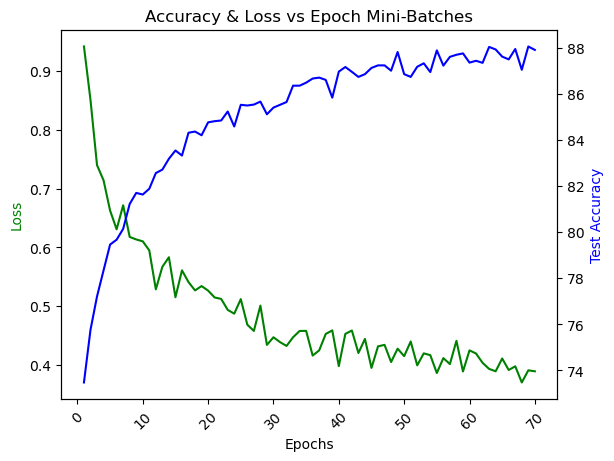

In [107]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()